In [3]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.use_jedi = False

In [4]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import os
from tensorflow import keras
from keras import layers

# Setup

In [9]:
# create a path to the pokemon image directory
data_directory = os.path.join(os.getcwd(), 'data')
pokemon_directory = os.path.join(data_directory, 'pokemon-high.csv')
df = pd.read_csv(pokemon_directory)
df.head()


,ID,Filepath,Name,Type1
0,001,/Users/judith/code-projects/pokemastery-projec...,bulbasaur,grass
1,002,/Users/judith/code-projects/pokemastery-projec...,ivysaur,grass
2,003,/Users/judith/code-projects/pokemastery-projec...,venusaur,grass
3,003-mega,/Users/judith/code-projects/pokemastery-projec...,venusaur,grass
4,004,/Users/judith/code-projects/pokemastery-projec...,charmander,fire


In [10]:
# limit data to Fire and Water types
df = df.query("Type1 == 'fire' | Type1 == 'water'")
df.head()

,ID,Filepath,Name,Type1
4,004,/Users/judith/code-projects/pokemastery-projec...,charmander,fire
5,005,/Users/judith/code-projects/pokemastery-projec...,charmeleon,fire
6,006,/Users/judith/code-projects/pokemastery-projec...,charizard,fire
7,006-mega-x,/Users/judith/code-projects/pokemastery-projec...,charizard,fire
8,006-mega-y,/Users/judith/code-projects/pokemastery-projec...,charizard,fire


In [11]:
print("Number of water-types:", len(df[df['Type1'] == 'water']))
print("Number of fire-types:", len(df[df['Type1'] == 'fire']))

Number of water-types: 145
Number of fire-types: 70


In [12]:
# shuffle the data
df = df.sample(frac=1).reset_index(drop=True)

train_gen = keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2,   # split the dataset into a training set and a validation set in an 8:2 ratio
    rescale=1./255          # rescale the rgb values to fit between 0 and 1 
)
train_gen 

In [13]:
train_data = train_gen.flow_from_dataframe(
    df,
    x_col='Filepath',
    y_col='Type1',
    target_size=(120, 120),
    color_mode='rgba',
    class_mode='sparse',
    batch_size=32,
    seed=1,
    subset='training'
)
train_data

Found 172 validated image filenames belonging to 2 classes.


In [14]:
val_data = train_gen.flow_from_dataframe(
    df,
    x_col='Filepath',
    y_col='Type1',
    target_size=(120, 120),
    color_mode='rgba',
    class_mode='sparse',
    batch_size=32,
    seed=1,
    subset='validation'
)
val_data

Found 43 validated image filenames belonging to 2 classes.


In [18]:
img_input = layers.Input(shape=(120, 120, 4))

x = layers.Conv2D(filters=64, kernel_size=(8, 8), activation='relu')(img_input)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(filters=128, kernel_size=(8, 8), activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(filters=256, kernel_size=(8, 8), activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)

output = layers.Dense(units=1, activation='sigmoid')(x)

model = keras.Model(inputs=img_input, outputs=output)

model.compile(
    optimizer='adam',                 
    loss='binary_crossentropy',
    metrics=['acc', keras.metrics.AUC()]
)

# print model layers
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 120, 120, 4)]     0         
                                                                 
 conv2d_11 (Conv2D)          (None, 113, 113, 64)      16448     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 56, 56, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 49, 49, 128)       524416    
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 24, 24, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 17, 17, 256)       2097

In [19]:
history = model.fit(
    train_data,
    validation_data=val_data,
    batch_size=32,
    epochs=100,
    callbacks=[
        # keras.callbacks.EarlyStopping(
        #     monitor='val_loss',
        #     patience=3,
        #     restore_best_weights=True
        # ),
        keras.callbacks.ReduceLROnPlateau()
    ]
)

Epoch 1/100
6/6 [==============================] - 18s 3s/step - loss: 3.4838 - acc: 0.5698 - auc_1: 0.4004 - val_loss: 0.8324 - val_acc: 0.6047 - val_auc_1: 0.4480 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 17s 3s/step - loss: 0.6720 - acc: 0.6919 - auc_1: 0.5467 - val_loss: 0.7079 - val_acc: 0.6047 - val_auc_1: 0.8631 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 17s 3s/step - loss: 0.5767 - acc: 0.7616 - auc_1: 0.6940 - val_loss: 0.6809 - val_acc: 0.6047 - val_auc_1: 0.9095 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 17s 3s/step - loss: 0.5752 - acc: 0.7500 - auc_1: 0.7213 - val_loss: 0.4947 - val_acc: 0.6279 - val_auc_1: 0.8891 - lr: 0.0010
Epoch 5/100
6/6 [==============================] - 18s 3s/step - loss: 0.4727 - acc: 0.7384 - auc_1: 0.8403 - val_loss: 0.4384 - val_acc: 0.8837 - val_auc_1: 0.9197 - lr: 0.0010
Epoch 6/100
6/6 [==============================] - 18s 3s/step - loss: 0.4758 - acc: 0.8198 - auc_1: 0.8813 - 

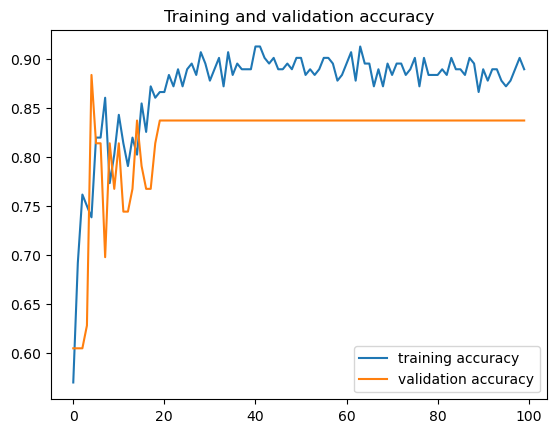

In [20]:

# retrieve accuracy history on training and validation data
acc = history.history['acc']
val_acc = history.history['val_acc']

# retrieve loss history on training and validation data
loss = history.history['loss']
val_loss = history.history['val_loss']

# get number of epochs
epochs = range(len(acc))

# plot training and validation accuracy per epoch
plt.plot(epochs, acc, label='training accuracy')
plt.plot(epochs, val_acc, label='validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

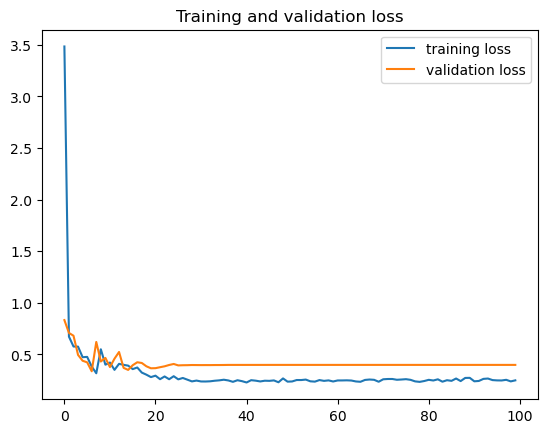

In [21]:
# plot training and validation loss per epoch
plt.figure()
plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.title('Training and validation loss')
plt.legend()

In [22]:
# get true labels
true_labels = val_data.labels

# get predictions in the form of probablities 
predictions = model.predict(val_data)
predictions

# convert probablities into binary values 
predictions = [1 if n >= 0.5 else 0 for n in predictions]
print("Model predictions: "+str(predictions))
print("Actual labels:     "+str(true_labels))

2/2 [==============================] - 3s 606ms/step
Model predictions: [1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1]
Actual labels:     [1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1]


In [23]:
# determine filepaths of misclassified pokemon
num_misclasssified = 0
misclassified_filepaths = []
correctness = []
for pred, label, i in zip(predictions, true_labels, range(len(predictions))):
  misclassified_filepaths.append(val_data.filepaths[i])
  if pred != label:
    correctness.append('incorrect')
    num_misclasssified += 1
  else:
    correctness.append('correct')

print("# of misclassified pokemon: "+str(num_misclasssified))
     

# of misclassified pokemon: 21


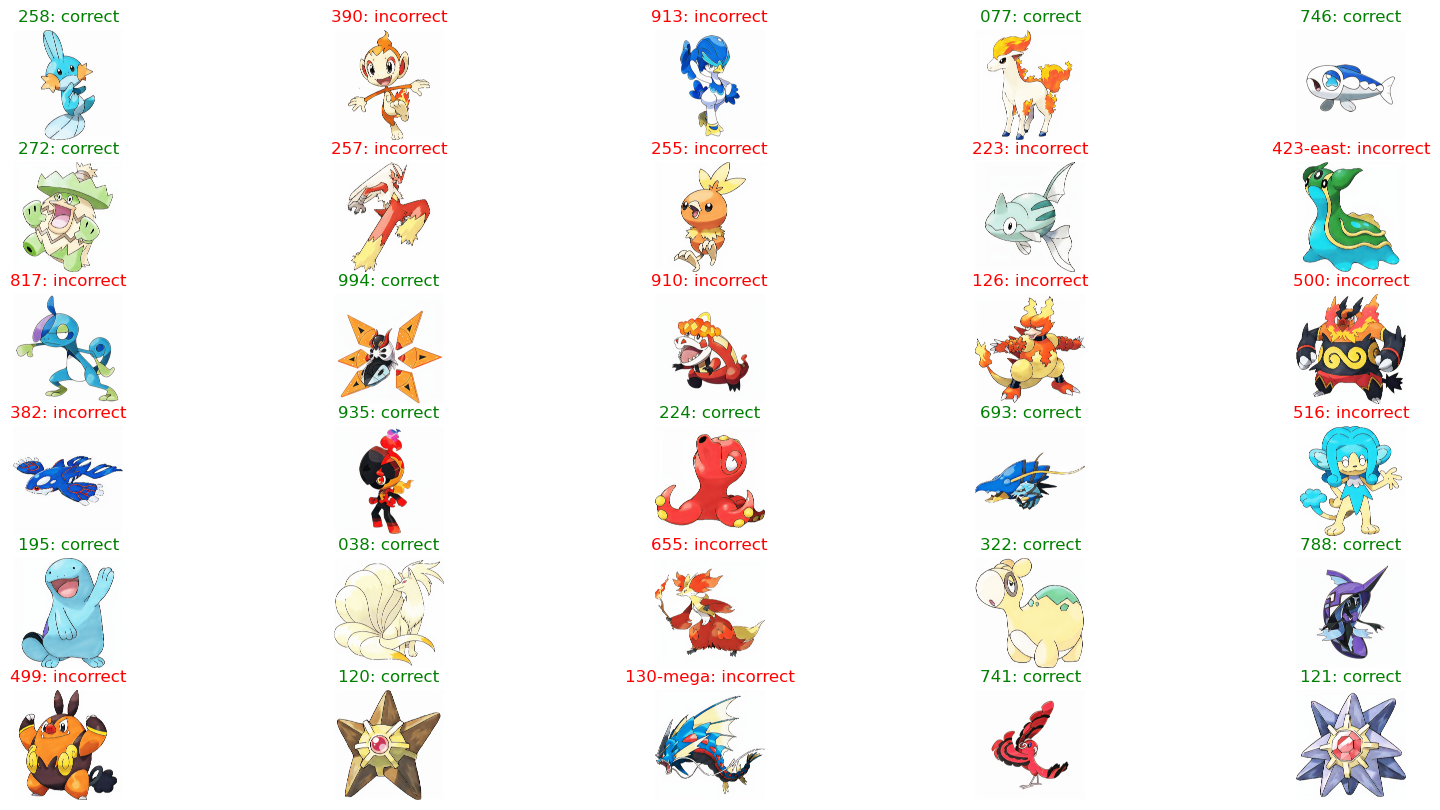

In [24]:
# obtain the images from the filepath at the determined indices
misclassified_imgs = []
names = []
for filepath in misclassified_filepaths:
  misclassified_imgs.append(mpimg.imread(filepath))
  names.append(filepath.split('/')[-1].split('.')[0])

# plot results
f, axarr = plt.subplots(6,5, figsize=(20,10))  
count = 0
for r in range(6):
  for c in range(5):
    axarr[r,c].imshow(misclassified_imgs[count])
    if correctness[count] == 'correct':
      axarr[r,c].set_title(f'{names[count]}: {correctness[count]}', color='green')
    else:
      axarr[r,c].set_title(f'{names[count]}: {correctness[count]}', color='red')
    axarr[r,c].set_axis_off()
    count += 1 
plt.show()
     